In [1]:
# definitive 

In [1]:
#%%
# =============================================================================
# CELL 1: IMPORTS & CONFIGURATION
# =============================================================================
import pandas as pd
import statsmodels.formula.api as smf
import os
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt # Import for plotting
import statsmodels.tools.sm_exceptions # Import for warning handling

# Suppress common warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=statsmodels.tools.sm_exceptions.ValueWarning)

#%%


In [2]:
# =============================================================================
# CELL 2: HELPER FUNCTIONS (PLOTTING & PRINTING)
# =============================================================================

def print_did_event_study_coeffs(results, title, variable="MONTH", ddd_term=None, policy_month=7):
    """
    Finds, prints, and returns a DataFrame of event study coefficients
    from a statsmodels results object.
    'variable' argument is used to build the regex pattern.
    'ddd_term' specifies the third interaction term (e.g., 'LowWage')
    'policy_month' is the first month of the post-period (e.g., 7 for July)
    """
    print("\n" + "="*60 + f"\n>>> Event Study Numerical Results: {title} <<<\n" + "="*60)
    
    # --- *** MODIFIED FOR DDD *** ---
    # --- FIX: Escape parentheses in C(TreatState) ---
    interaction_base = rf"C\(TreatState\)\[T\.1\]:C({variable})" # Escaped ( ) [ . ]
    if ddd_term:
        # --- FIX: Escape parentheses in C(TreatState) ---
        interaction_full = rf"C\(TreatState\)\[T\.1\]:C\({variable}.*?\[T\.(\d+)\]:{ddd_term}$"
        print(f"Coefficients for: {interaction_base} * {ddd_term} interactions")
    else:
        # --- FIX: Escape parentheses in C(TreatState) ---
        interaction_full = rf"C\(TreatState\)\[T\.1\]:C\({variable}.*?\[T\.(\d+)\]$"
        print(f"Coefficients for: {interaction_base} interactions")
        
    print(f"Checking PTA: Pre-trend p-values (Months < {policy_month}) should be > 0.10")
    print("-" * 60)
    
    did_terms = []
    term_pattern = rf'{interaction_full}'
    
    # Find the reference level from the formula if possible
    ref_month = 2 # Defaulting to 2 (February) as per our formula
    try:
        ref_match = re.search(r'C\(MONTH, Treatment\(reference=(\d+)\)\)', results.model.formula)
        if ref_match:
            ref_month = int(ref_match.group(1))
    except:
        pass # Keep default

    for var in results.params.index:
        match = re.search(term_pattern, var, re.IGNORECASE) # Add re.IGNORECASE for flexibility
        if match:
            month = int(match.group(1))
            did_terms.append({
                'relative_month': month, # Keeping col name 'relative_month' for plotting
                'coef': results.params[var],
                'pval': results.pvalues[var],
                'stderr': results.bse[var]
            })
            
    if not did_terms:
        print("No event study coefficients found.")
        print(f"Pattern searched for: {term_pattern}")
        print("This often means the control group was dropped or there is perfect collinearity.")
        print("Check if the variable names in the regex match the model output *exactly*.")
        print("-" * 60)
        return None
        
    est_df = pd.DataFrame(did_terms).sort_values('relative_month')
    
    # Add the reference month with coef=0
    if ref_month not in est_df['relative_month'].values:
        ref_month_df = pd.DataFrame([{'relative_month': ref_month, 'coef': 0, 'stderr': 0, 'pval': 1.0}])
        plot_df = pd.concat([est_df, ref_month_df]).sort_values('relative_month').reset_index(drop=True)
    else:
        plot_df = est_df.copy()
    
    # Print the table
    for _, row in plot_df.iterrows():
        print(f"Month {int(row.relative_month):>2}:  Coef = {row.coef:>7.4f},  SE = {row.stderr:>6.4f},  P = {row.pval:.4f}")
    print("-" * 60)
    
    # Check PTA (Policy starts in policy_month)
    pre_trend_pvals = plot_df[plot_df['relative_month'] < policy_month]['pval']
    if pre_trend_pvals.empty:
        print(f"No pre-trends (< {policy_month}) to test.")
    # Check if all p-values (excl. ref month) are > 0.10
    elif (pre_trend_pvals[plot_df['relative_month'] != ref_month] > 0.10).all():
        print("SUCCESS: Parallel Trends Assumption appears satisfied.")
    else:
        print("WARNING: Parallel Trends Assumption may be VIOLATED.")
        
    return plot_df

def plot_did_event_study(plot_df, title):
    """
    Plots the event study coefficients and 95% confidence intervals.
    """
    if plot_df is None or plot_df.empty:
        print(f"Skipping plot {title}: No data.");
        return
        
    plt.figure(figsize=(10, 6))
    # Reference lines
    plt.axhline(0, color='black', linewidth=1, linestyle='-')
    plt.axvline(6.5, color='gray', linestyle='--', linewidth=1, label='Policy Change (July)') # Keep as July for comparison
    
    # Calculate 95% CI
    plot_df['ci_low'] = plot_df['coef'] - 1.96 * plot_df['stderr']
    plot_df['ci_high'] = plot_df['coef'] + 1.96 * plot_df['stderr']
    
    # Plot CI band and coefficients
    plt.fill_between(plot_df['relative_month'], plot_df['ci_low'], plot_df['ci_high'], color='lightblue', alpha=0.4, label='95% CI')
    plt.plot(plot_df['relative_month'], plot_df['coef'], marker='o', linestyle='-', color='darkblue', label='DiD Coefficient')
    
    plt.title(title, fontsize=16)
    plt.xlabel("Calendar Month", fontsize=12) # Generic x-axis label
    plt.ylabel("DDD Coefficient (PP)", fontsize=12)
    plt.xticks(plot_df['relative_month'].unique()) # Shows 2, 3, 4, 5, 6, 7, 8
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Save the figure
    safe_title = title.replace(' ','_').replace('(','').replace(')','').replace(',','').lower()
    plt.savefig(f"{safe_title}.png")
    plt.show()

#%%



In [3]:
# =============================================================================
# CELL 3: CORE ANALYSIS FUNCTIONS
# =============================================================================

def run_state_did_analysis(df, year, holzer_treat_fips, holzer_control_fips, monthly_covid, monthly_stringency, control_vars, policy_month=7):
    """
    Main analysis function for 2021 (main) and 2019 (placebo) using LOWWAGE (industry).
    """
    
    print("\n" + "="*80)
    print(f"--- RUNNING MAIN ANALYSIS (LowWage) FOR YEAR: {year} ---")
    print("="*80)

    # --- Step 3: Prepare Final STATE Panel ---
    print(f"\n--- Step 3: Preparing Final {year} STATE Panel (LowWage) ---")
    
    # Check for IND
    if 'IND' not in df.columns:
        print("ERROR: 'IND' (Industry) not found in CPS data.")
        return
    
    df_year = df[df['YEAR'] == year].copy()
    if df_year.empty:
        print(f"ERROR: No data found for {year}.")
        return
    
    included_states = holzer_treat_fips.union(holzer_control_fips)
    
    # --- *** MODIFIED: Define LowWage Group based on IND *** ---
    df_year['IND'] = pd.to_numeric(df_year['IND'], errors='coerce')
    
    def define_low_wage(x):
        if (4670 <= x < 5790) or (8560 <= x < 8700): 
            return 1
        elif x > 0: 
            return 0
        else:
            return np.nan 

    df_year['LowWage'] = df_year['IND'].apply(define_low_wage)
    print(f"Created 'LowWage' variable from 'IND'.")
    
    df_year = df_year[df_year['STATEFIP'].isin(included_states)].copy()
    df_year['TreatState'] = df_year['STATEFIP'].apply(lambda x: 1 if x in holzer_treat_fips else 0)
    df_year['date'] = pd.to_datetime(df_year['YEAR'].astype(str) + '-' + df_year['MONTH'].astype(str) + '-01')
    
    df_year.sort_values(['CPSIDP', 'YEAR', 'MONTH'], inplace=True)
    df_year['status_next_month'] = df_year.groupby('CPSIDP')['EMPSTAT'].shift(-1)
    unemployed_df = df_year[df_year['EMPSTAT'].between(20, 22)].copy() 
    unemployed_df['found_job'] = unemployed_df['status_next_month'].between(10, 12).astype(int) 
    
    # Define Post period (July/August)
    unemployed_df['Post'] = ((unemployed_df['MONTH'] >= policy_month) & (unemployed_df['MONTH'] <= policy_month + 1)).astype(int)

    # Filter to Holzer's timeframe (Feb-Aug)
    final_panel = unemployed_df[unemployed_df['MONTH'].between(2, 8)].copy()
    
    # Keep only essential columns + weights + IDs for clustering
    essential_cols = ['found_job', 'LNKFW1MWT', 'STATEFIP', 'MONTH', 'YEAR', 'TreatState', 'Post', 'date', 'LowWage']
    final_panel = final_panel.dropna(subset=['found_job', 'LNKFW1MWT', 'LowWage']) 
    final_panel = final_panel[final_panel['LNKFW1MWT'] > 0] 
    final_panel['LowWage'] = final_panel['LowWage'].astype(int) 
    
    print(f"Base {year} panel (Holzer States, Feb-Aug, valid industry) constructed with {len(final_panel)} observations.")
    print(f"Other Wage (n={len(final_panel[final_panel['LowWage']==0])}), Low Wage (n={len(final_panel[final_panel['LowWage']==1])})")

    # --- Step 4: Merge Controls ---
    print(f"\n--- Step 4: Merging Controls into {year} panel (LowWage) ---")
    
    # Filter controls for the specific year
    monthly_covid_year = monthly_covid[monthly_covid['YEAR'] == year]
    
    final_panel_with_controls = pd.merge(final_panel, monthly_covid_year, on=['STATEFIP', 'YEAR', 'MONTH'], how='left')
    
    current_control_vars = [] # Start with none
    
    # --- *** 2019 PLACEBO FIX *** ---
    # Only add COVID cases as a control variable for 2020+
    if year > 2019:
        current_control_vars.append('log_monthly_cases')
    # --- *** END FIX *** ---

    if not monthly_stringency.empty:
        monthly_stringency_year = monthly_stringency[monthly_stringency['YEAR'] == year]
        if not monthly_stringency_year.empty:
            final_panel_with_controls = pd.merge(final_panel_with_controls, monthly_stringency_year, on=['STATEFIP', 'YEAR', 'MONTH'], how='left')
            current_control_vars.append('avg_stringency')
        
    original_count = len(final_panel_with_controls)
    
    # --- *** 2019 PLACEBO FIX *** ---
    # Drop only if controls (if any) are missing. For 2019, this list will be empty
    # unless stringency data for 2019 is found.
    if current_control_vars: # Only drop if there are controls to check
        final_panel_with_controls.dropna(subset=current_control_vars, inplace=True)
    # --- *** END FIX *** ---

    dropped_count = original_count - len(final_panel_with_controls)
    if dropped_count > 0:
        print(f"Warning: Dropped {dropped_count} observations missing control data.")
        
    print(f"Final {year} panel with controls constructed with {len(final_panel_with_controls)} observations.")
    if len(final_panel_with_controls) == 0:
        print(f"ERROR: Panel for {year} is empty after merging controls."); return

    # --- Step 5: Run State-Level DDD Model (LowWage) ---
    print("\n" + "="*80)
    print(f">>> FINAL MODEL: DDD ({year}, All Ages, Holzer States, LowWage) <<<")
    print("="*80)
    
    formula_parts = ["found_job ~ TreatState * Post * LowWage", "C(STATEFIP)", "C(MONTH)"]
    
    # --- *** 2019 PLACEBO FIX *** ---
    # Conditionally add controls to formula
    if 'log_monthly_cases' in current_control_vars:
        formula_parts.insert(1, "log_monthly_cases")
    if 'avg_stringency' in current_control_vars:
        formula_parts.insert(1, "avg_stringency") # Insert at 1, so cases is 2
    # --- *** END FIX *** ---
        
    final_formula = " + ".join(formula_parts)
    print(f"Using formula:\n{final_formula}")
    
    print(f"\nStarting {year} DDD model estimation...")
    try:
        model_ddd = smf.wls(formula=final_formula, data=final_panel_with_controls, weights=final_panel_with_controls['LNKFW1MWT'])
        results_ddd = model_ddd.fit(cov_type='cluster', cov_kwds={'groups': final_panel_with_controls['STATEFIP']})
        
        ddd_term = 'TreatState:Post:LowWage'
        if ddd_term in results_ddd.params:
            coef_ddd = results_ddd.params[ddd_term]
            pval_ddd = results_ddd.pvalues[ddd_term]
            
            print(f"\n--- DDD Results ({year}, All Ages, Holzer States, LowWage) ---")
            print(f"Key Coefficient ({ddd_term}): {coef_ddd:.4f}")
            print(f"P-value: {pval_ddd:.4f}\n")
            
            print("--- Coefficient Summary (Key Variables) ---")
            key_vars_to_print = [ddd_term, 'TreatState:Post', 'TreatState:LowWage', 'Post:LowWage'] + [v for v in current_control_vars if v in results_ddd.params.index]
            for var in key_vars_to_print:
                if var in results_ddd.params:
                    print(f"{var:<25}: Coef = {results_ddd.params[var]:>8.4f}, P-val = {results_ddd.pvalues[var]:.4f}")
            
            print("\n--- Interpretation ---")
            if year == 2019:
                if pval_ddd < 0.10: print(f"PLACEBO TEST FAILED: Found a significant effect (p={pval_ddd:.3f}) in placebo year.")
                else: print(f"PLACEBO TEST PASSED: No significant effect found (p={pval_ddd:.3f}).")
            else:
                if pval_ddd < 0.10: print(f"Result: Found a statistically significant differential effect (p={pval_ddd:.3f}).")
                else: print(f"Result: No statistically significant differential effect found (p={pval_ddd:.3f}).")

        else: print(f"ERROR: '{ddd_term}' coefficient was not estimated.")

    except Exception as e:
        print(f"\nAn error occurred during {year} DDD estimation: {e}")

    # --- Step 5b: Run Separate DiD Models by Wage Group ---
    print("\n" + "="*80)
    print(f">>> Step 5b: Separate 2x2 DiD Models by Wage Group ({year}, LowWage) <<<")
    print("="*80)
    
    other_wage_panel = final_panel_with_controls[final_panel_with_controls['LowWage'] == 0].copy()
    low_wage_panel = final_panel_with_controls[final_panel_with_controls['LowWage'] == 1].copy()
    print(f"Running DiD for Other Wage group (n={len(other_wage_panel)})")
    print(f"Running DiD for Low Wage group (n={len(low_wage_panel)})")

    formula_parts_simple_did = ["found_job ~ TreatState * Post", "C(STATEFIP)", "C(MONTH)"]
    # --- *** 2019 PLACEBO FIX *** ---
    if 'log_monthly_cases' in current_control_vars:
        formula_parts_simple_did.insert(1, "log_monthly_cases")
    if 'avg_stringency' in current_control_vars:
        formula_parts_simple_did.insert(1, "avg_stringency")
    # --- *** END FIX *** ---
    simple_did_formula = " + ".join(formula_parts_simple_did)
    
    print(f"\nUsing simple DiD formula: {simple_did_formula}")

    try:
        model_did_other = smf.wls(formula=simple_did_formula, data=other_wage_panel, weights=other_wage_panel['LNKFW1MWT'])
        results_did_other = model_did_other.fit(cov_type='cluster', cov_kwds={'groups': other_wage_panel['STATEFIP']})
        
        coef_did_other = results_did_other.params.get('TreatState:Post', np.nan)
        pval_did_other = results_did_other.pvalues.get('TreatState:Post', np.nan)
        
        print(f"\n--- DiD Results for OTHER WAGE Group (LowWage=0) [{year}] ---")
        print(f"Key Coefficient (TreatState:Post): {coef_did_other:.4f}")
        print(f"P-value: {pval_did_other:.4f}")
        if pval_did_other < 0.10: print(f"Result: Statistically SIGNIFICANT effect (p={pval_did_other:.3f}).")
        else: print(f"Result: NOT statistically significant (p={pval_did_other:.3f}).")
        
    except Exception as e:
        print(f"\nAn error occurred during {year} Other Wage DiD estimation: {e}")

    try:
        model_did_low = smf.wls(formula=simple_did_formula, data=low_wage_panel, weights=low_wage_panel['LNKFW1MWT'])
        results_did_low = model_did_low.fit(cov_type='cluster', cov_kwds={'groups': low_wage_panel['STATEFIP']})
        
        coef_did_low = results_did_low.params.get('TreatState:Post', np.nan)
        pval_did_low = results_did_low.pvalues.get('TreatState:Post', np.nan)
        
        print(f"\n--- DiD Results for LOW WAGE Group (LowWage=1) [{year}] ---")
        print(f"Key Coefficient (TreatState:Post): {coef_did_low:.4f}")
        print(f"P-value: {pval_did_low:.4f}")
        if pval_did_low < 0.10: print(f"Result: Statistically SIGNIFICANT effect (p={pval_did_low:.3f}).")
        else: print(f"Result: NOT statistically significant (p={pval_did_low:.3f}).")
        
    except Exception as e:
        print(f"\nAn error occurred during {year} Low Wage DiD estimation: {e}")
    
    # --- Step 6: Run Event Study for Validation (DDD) ---
    print("\n" + "="*80)
    print(f">>> VALIDATION: Event Study on DDD Model (LowWage) ({year}) <<<")
    print("="*80)

    formula_es_parts = ["found_job ~ C(TreatState) * C(MONTH, Treatment(reference=2)) * LowWage", "C(STATEFIP)"]
    # --- *** 2019 PLACEBO FIX *** ---
    if 'log_monthly_cases' in current_control_vars:
        formula_es_parts.insert(1, "log_monthly_cases")
    if 'avg_stringency' in current_control_vars:
        formula_es_parts.insert(1, "avg_stringency")
    # --- *** END FIX *** ---
        
    final_formula_es = " + ".join(formula_es_parts)
    print(f"\nUsing event study formula:\n{final_formula_es}")
    
    print(f"\nStarting {year} DDD event study estimation...")
    try:
        es_data = final_panel_with_controls.copy()
        print(f"Running event study on {len(es_data)} observations.")
        
        model_es = smf.wls(formula=final_formula_es, data=es_data, weights=es_data['LNKFW1MWT'])
        results_es = model_es.fit(cov_type='cluster', cov_kwds={'groups': es_data['STATEFIP']})
        
        plot_df_ddd = print_did_event_study_coeffs(
            results_es, 
            f"DDD_State_AllAges_HolzerStates_LowWage_{year}", 
            variable="MONTH", 
            ddd_term="LowWage",
            policy_month=policy_month
        )
        plot_did_event_study(plot_df_ddd, f"DDD State Event Study ({year}, LowWage vs Other-Wage)")

    except Exception as e:
        print(f"\nAn error occurred during {year} event study estimation: {e}")
        import traceback
        traceback.print_exc()

def run_college_grad_sensitivity_test(df, year, holzer_treat_fips, holzer_control_fips, monthly_covid, monthly_stringency, control_vars, policy_month=7):
    """
    SENSITIVITY TEST function for 2021 using CollegeGrad (education).
    """
    
    print("\n" + "="*80)
    print(f"--- RUNNING SENSITIVITY TEST (CollegeGrad) FOR YEAR: {year} ---")
    print("="*80)

    # --- Step 3: Prepare Final STATE Panel ---
    print(f"\n--- Step 3: Preparing Final {year} STATE Panel (CollegeGrad) ---")
    
    # Check for EDUC
    if 'EDUC' not in df.columns:
        print("ERROR: 'EDUC' (Education) not found in CPS data. Skipping sensitivity test.")
        return
    
    df_year = df[df['YEAR'] == year].copy()
    if df_year.empty:
        print(f"ERROR: No data found for {year}.")
        return
    
    included_states = holzer_treat_fips.union(holzer_control_fips)
    
    # --- *** DEFINE CollegeGrad Group based on EDUC *** ---
    # EDUC >= 111 (Bachelor's degree)
    df_year['EDUC'] = pd.to_numeric(df_year['EDUC'], errors='coerce')
    
    def define_college_grad(x):
        if x >= 111: # Bachelor's degree or higher
            return 1
        elif x > 0: # All other valid education codes
            return 0
        else:
            return np.nan 

    df_year['CollegeGrad'] = df_year['EDUC'].apply(define_college_grad)
    print(f"Created 'CollegeGrad' variable from 'EDUC'.")
    
    df_year = df_year[df_year['STATEFIP'].isin(included_states)].copy()
    df_year['TreatState'] = df_year['STATEFIP'].apply(lambda x: 1 if x in holzer_treat_fips else 0)
    df_year['date'] = pd.to_datetime(df_year['YEAR'].astype(str) + '-' + df_year['MONTH'].astype(str) + '-01')
    
    df_year.sort_values(['CPSIDP', 'YEAR', 'MONTH'], inplace=True)
    df_year['status_next_month'] = df_year.groupby('CPSIDP')['EMPSTAT'].shift(-1)
    unemployed_df = df_year[df_year['EMPSTAT'].between(20, 22)].copy() 
    unemployed_df['found_job'] = unemployed_df['status_next_month'].between(10, 12).astype(int) 
    
    # Define Post period (July/August)
    unemployed_df['Post'] = ((unemployed_df['MONTH'] >= policy_month) & (unemployed_df['MONTH'] <= policy_month + 1)).astype(int)

    # Filter to Holzer's timeframe (Feb-Aug)
    final_panel = unemployed_df[unemployed_df['MONTH'].between(2, 8)].copy()
    
    # Keep only essential columns + weights + IDs for clustering
    final_panel = final_panel.dropna(subset=['found_job', 'LNKFW1MWT', 'CollegeGrad']) 
    final_panel = final_panel[final_panel['LNKFW1MWT'] > 0] 
    final_panel['CollegeGrad'] = final_panel['CollegeGrad'].astype(int) 
    
    print(f"Base {year} panel (Holzer States, Feb-Aug, valid education) constructed with {len(final_panel)} observations.")
    print(f"Not College Grad (n={len(final_panel[final_panel['CollegeGrad']==0])}), College Grad (n={len(final_panel[final_panel['CollegeGrad']==1])})")

    # --- Step 4: Merge Controls ---
    print(f"\n--- Step 4: Merging Controls into {year} panel (CollegeGrad) ---")
    
    # Filter controls for the specific year
    monthly_covid_year = monthly_covid[monthly_covid['YEAR'] == year]
    
    final_panel_with_controls = pd.merge(final_panel, monthly_covid_year, on=['STATEFIP', 'YEAR', 'MONTH'], how='left')
    
    current_control_vars = [] # Start with none
    
    # --- *** 2019 PLACEBO FIX *** ---
    if year > 2019:
        current_control_vars.append('log_monthly_cases')
    # --- *** END FIX *** ---
    
    if not monthly_stringency.empty:
        monthly_stringency_year = monthly_stringency[monthly_stringency['YEAR'] == year]
        if not monthly_stringency_year.empty:
            final_panel_with_controls = pd.merge(final_panel_with_controls, monthly_stringency_year, on=['STATEFIP', 'YEAR', 'MONTH'], how='left')
            current_control_vars.append('avg_stringency')
        
    original_count = len(final_panel_with_controls)
    
    # --- *** 2019 PLACEBO FIX *** ---
    if current_control_vars:
        final_panel_with_controls.dropna(subset=current_control_vars, inplace=True)
    # --- *** END FIX *** ---

    dropped_count = original_count - len(final_panel_with_controls)
    if dropped_count > 0:
        print(f"Warning: Dropped {dropped_count} observations missing control data.")
        
    print(f"Final {year} panel with controls constructed with {len(final_panel_with_controls)} observations.")
    if len(final_panel_with_controls) == 0:
        print(f"ERROR: Panel for {year} is empty after merging controls."); return

    # --- Step 5: Run State-Level DDD Model (CollegeGrad) ---
    print("\n" + "="*80)
    print(f">>> SENSITIVITY MODEL: DDD ({year}, All Ages, Holzer States, CollegeGrad) <<<")
    print("="*80)
    
    formula_parts = ["found_job ~ TreatState * Post * CollegeGrad", "C(STATEFIP)", "C(MONTH)"]
    # --- *** 2019 PLACEBO FIX *** ---
    if 'log_monthly_cases' in current_control_vars:
        formula_parts.insert(1, "log_monthly_cases")
    if 'avg_stringency' in current_control_vars:
        formula_parts.insert(1, "avg_stringency")
    # --- *** END FIX *** ---
        
    final_formula = " + ".join(formula_parts)
    print(f"Using formula:\n{final_formula}")
    
    print(f"\nStarting {year} DDD model estimation...")
    try:
        model_ddd = smf.wls(formula=final_formula, data=final_panel_with_controls, weights=final_panel_with_controls['LNKFW1MWT'])
        results_ddd = model_ddd.fit(cov_type='cluster', cov_kwds={'groups': final_panel_with_controls['STATEFIP']})
        
        ddd_term = 'TreatState:Post:CollegeGrad'
        if ddd_term in results_ddd.params:
            coef_ddd = results_ddd.params[ddd_term]
            pval_ddd = results_ddd.pvalues[ddd_term]
            
            print(f"\n--- DDD Results ({year}, All Ages, Holzer States, CollegeGrad) ---")
            print(f"Key Coefficient ({ddd_term}): {coef_ddd:.4f}")
            print(f"P-value: {pval_ddd:.4f}\n")
            
            print("--- Coefficient Summary (Key Variables) ---")
            key_vars_to_print = [ddd_term, 'TreatState:Post', 'TreatState:CollegeGrad', 'Post:CollegeGrad'] + [v for v in current_control_vars if v in results_ddd.params.index]
            for var in key_vars_to_print:
                if var in results_ddd.params:
                    print(f"{var:<25}: Coef = {results_ddd.params[var]:>8.4f}, P-val = {results_ddd.pvalues[var]:.4f}")
            
            print("\n--- Interpretation ---")
            if pval_ddd < 0.10: print(f"Result: Found a statistically significant differential effect (p={pval_ddd:.3f}).")
            else: print(f"Result: No statistically significant differential effect found (p={pval_ddd:.3f}).")
            print("This tests if the effect for College Grads was different from non-grads.")

        else: print(f"ERROR: '{ddd_term}' coefficient was not estimated.")

    except Exception as e:
        print(f"\nAn error occurred during {year} DDD estimation: {e}")

    # --- Step 5b: Run Separate DiD Models by Wage Group ---
    print("\n" + "="*80)
    print(f">>> Step 5b: Separate 2x2 DiD Models by Group ({year}, CollegeGrad) <<<")
    print("="*80)
    
    non_grad_panel = final_panel_with_controls[final_panel_with_controls['CollegeGrad'] == 0].copy()
    grad_panel = final_panel_with_controls[final_panel_with_controls['CollegeGrad'] == 1].copy()
    print(f"Running DiD for Not College Grad group (n={len(non_grad_panel)})")
    print(f"Running DiD for College Grad group (n={len(grad_panel)})")

    formula_parts_simple_did = ["found_job ~ TreatState * Post", "C(STATEFIP)", "C(MONTH)"]
    # --- *** 2019 PLACEBO FIX *** ---
    if 'log_monthly_cases' in current_control_vars:
        formula_parts_simple_did.insert(1, "log_monthly_cases")
    if 'avg_stringency' in current_control_vars:
        formula_parts_simple_did.insert(1, "avg_stringency")
    # --- *** END FIX *** ---
    simple_did_formula = " + ".join(formula_parts_simple_did)
    
    print(f"\nUsing simple DiD formula: {simple_did_formula}")

    try:
        model_did_other = smf.wls(formula=simple_did_formula, data=non_grad_panel, weights=non_grad_panel['LNKFW1MWT'])
        results_did_other = model_did_other.fit(cov_type='cluster', cov_kwds={'groups': non_grad_panel['STATEFIP']})
        
        coef_did_other = results_did_other.params.get('TreatState:Post', np.nan)
        pval_did_other = results_did_other.pvalues.get('TreatState:Post', np.nan)
        
        print(f"\n--- DiD Results for NOT COLLEGE GRAD Group (CollegeGrad=0) [{year}] ---")
        print(f"Key Coefficient (TreatState:Post): {coef_did_other:.4f}")
        print(f"P-value: {pval_did_other:.4f}")
        if pval_did_other < 0.10: print(f"Result: Statistically SIGNIFICANT effect (p={pval_did_other:.3f}).")
        else: print(f"Result: NOT statistically significant (p={pval_did_other:.3f}).")
        
    except Exception as e:
        print(f"\nAn error occurred during {year} Not College Grad DiD estimation: {e}")

    try:
        model_did_low = smf.wls(formula=simple_did_formula, data=grad_panel, weights=grad_panel['LNKFW1MWT'])
        results_did_low = model_did_low.fit(cov_type='cluster', cov_kwds={'groups': grad_panel['STATEFIP']})
        
        coef_did_low = results_did_low.params.get('TreatState:Post', np.nan)
        pval_did_low = results_did_low.pvalues.get('TreatState:Post', np.nan)
        
        print(f"\n--- DiD Results for COLLEGE GRAD Group (CollegeGrad=1) [{year}] ---")
        print(f"Key Coefficient (TreatState:Post): {coef_did_low:.4f}")
        print(f"P-value: {pval_did_low:.4f}")
        if pval_did_low < 0.10: print(f"Result: Statistically SIGNIFICANT effect (p={pval_did_low:.3f}).")
        else: print(f"Result: NOT statistically significant (p={pval_did_low:.3f}).")
        
    except Exception as e:
        print(f"\nAn error occurred during {year} College Grad DiD estimation: {e}")
    
    # --- Step 6: Run Event Study for Validation (DDD) ---
    print("\n" + "="*80)
    print(f">>> VALIDATION: Event Study on DDD Model (CollegeGrad) ({year}) <<<")
    print("="*80)

    formula_es_parts = ["found_job ~ C(TreatState) * C(MONTH, Treatment(reference=2)) * CollegeGrad", "C(STATEFIP)"]
    # --- *** 2019 PLACEBO FIX *** ---
    if 'log_monthly_cases' in current_control_vars:
        formula_es_parts.insert(1, "log_monthly_cases")
    if 'avg_stringency' in current_control_vars:
        formula_es_parts.insert(1, "avg_stringency")
    # --- *** END FIX *** ---
        
    final_formula_es = " + ".join(formula_es_parts)
    print(f"\nUsing event study formula:\n{final_formula_es}")
    
    print(f"\nStarting {year} DDD event study estimation...")
    try:
        es_data = final_panel_with_controls.copy()
        print(f"Running event study on {len(es_data)} observations.")
        
        model_es = smf.wls(formula=final_formula_es, data=es_data, weights=es_data['LNKFW1MWT'])
        results_es = model_es.fit(cov_type='cluster', cov_kwds={'groups': es_data['STATEFIP']})
        
        plot_df_ddd = print_did_event_study_coeffs(
            results_es, 
            f"DDD_State_AllAges_HolzerStates_CollegeGrad_{year}", 
            variable="MONTH", 
            ddd_term="CollegeGrad",
            policy_month=policy_month
        )
        plot_did_event_study(plot_df_ddd, f"DDD State Event Study ({year}, CollegeGrad vs Not-Grad)")

    except Exception as e:
        print(f"\nAn error occurred during {year} event study estimation: {e}")
        import traceback
        traceback.print_exc()

#%%


In [9]:
# =============================================================================
# CELL 4: MAIN EXECUTION SCRIPT (MODIFIED FOR STAGGERED STATE DEFINITIONS)
# =============================================================================
import pandas as pd
import numpy as np
import os
import datetime # For date comparisons

# Assuming CELL 1 (Imports) and CELL 2 (Plotting/Printing Helpers) are defined
# Assuming CELL 3 (run_state_did_analysis, run_college_grad_sensitivity_test) are defined

def run_state_did_with_staggered_states(cps_file='cps_00005.csv',
                                        policy_file='Policy Milestones - State.csv',
                                        covid_file='COVID - State - Daily.csv',
                                        oxcgrt_file='OxCGRT_US_latest.csv'):
    """
    Main function modified to define treatment/control based on actual
    staggered UI termination dates from the policy file, then runs the
    original TWFE/DDD analysis from CELL 3.
    """
    # --- Step 0: Define Treatment/Control based on Policy File ---
    print("\n--- Step 0: Defining Treatment/Control States based on Policy File ---")
    try:
        home_dir = os.path.expanduser('~'); downloads_dir = os.path.join(home_dir, 'downloads')
        policy_path = os.path.join(downloads_dir, policy_file)
        policy_df = pd.read_csv(policy_path)
        # *** Parse dates correctly ***
        policy_df['date'] = pd.to_datetime(policy_df['date'], format='%Y-%m-%d', errors='coerce')
        policy_df.dropna(subset=['date'], inplace=True) # Drop rows where date failed to parse

        base_year = 2021
        base_month = 1
        federal_expiration_date = pd.to_datetime('2021-09-01')

        # --- Use corrected filter based on R script ---
        early_terminators_df = policy_df[
            policy_df['policy_description'].str.contains("end(s|ed) emergency employment benefits", na=False, case=False, regex=True) &
            (policy_df['date'] < federal_expiration_date)
        ].copy()

        # Keep earliest date per state
        early_terminators_df.sort_values(['statefips', 'date'], inplace=True)
        early_terminators_df.drop_duplicates(subset=['statefips'], keep='first', inplace=True)

        # Get the set of treated states (FIPS codes)
        staggered_treat_fips = set(early_terminators_df['statefips'].unique())

        if not staggered_treat_fips:
            print("ERROR: No early terminating states found with the filter. Check policy file and filter logic.")
            return

        # Need CPS data to define control states relative to available data
        cps_path = os.path.join(downloads_dir, cps_file)
        df_temp_cps = pd.read_csv(cps_path, usecols=['YEAR', 'STATEFIP']) # Load only needed cols
        cps_states_2021 = set(df_temp_cps[df_temp_cps['YEAR'] == 2021]['STATEFIP'].unique())
        del df_temp_cps # Free memory

        # Control states = states in 2021 CPS MINUS early terminators
        staggered_control_fips = cps_states_2021 - staggered_treat_fips

        if not staggered_control_fips:
            print("ERROR: No control states found (all states in 2021 CPS terminated early?).")
            return

        print(f"Defined Staggered Treatment States (n={len(staggered_treat_fips)}): {sorted(list(staggered_treat_fips))}")
        print(f"Defined Staggered Control States (n={len(staggered_control_fips)}): Based on 2021 CPS data minus treated.")
        # print(f"Control states: {sorted(list(staggered_control_fips))}") # Optionally print list

    except FileNotFoundError as e:
        print(f"ERROR: Could not find policy file or CPS file. {e}"); return
    except Exception as e:
        print(f"An error occurred during state definition: {e}"); return

    # --- Step 1 & 2: Load Data & Prepare Controls (Same as original notebook) ---
    print("\n--- Step 1 & 2: Loading Full Data & Preparing Controls ---")
    try:
        # Load CPS data (main file)
        df = pd.read_csv(cps_path) # Load full data now
        covid_df = pd.read_csv(os.path.join(downloads_dir, covid_file), na_values='.');
        ox_df = pd.read_csv(os.path.join(downloads_dir, oxcgrt_file), low_memory=False)

        available_years = sorted(df['YEAR'].unique())
        print(f"Full data loaded. Available years: {available_years}")

        # Prepare Controls (copied from original notebook's Cell 4)
        if 'new_case_count' not in covid_df.columns: raise ValueError("'new_case_count' missing.")
        covid_df['new_cases_numeric'] = pd.to_numeric(covid_df['new_case_count'], errors='coerce').fillna(0)
        monthly_covid = covid_df.groupby(['statefips', 'year', 'month'])['new_cases_numeric'].sum().reset_index()
        monthly_covid.rename(columns={'statefips': 'STATEFIP', 'year': 'YEAR', 'month': 'MONTH', 'new_cases_numeric': 'monthly_cases'}, inplace=True)
        monthly_covid['log_monthly_cases'] = np.log(monthly_covid['monthly_cases'] + 1)

        monthly_stringency = pd.DataFrame()
        control_vars = ['log_monthly_cases']
        try:
            ox_df['date'] = pd.to_datetime(ox_df['Date'], format='%Y%m%d')
            ox_df['YEAR'] = ox_df['date'].dt.year; ox_df['MONTH'] = ox_df['date'].dt.month
            ox_us_states = ox_df[(ox_df['CountryCode'] == 'USA') & (ox_df['Jurisdiction'] == 'STATE_TOTAL') & (ox_df['YEAR'].isin(available_years))].copy()
            ox_us_states['StringencyIndex_numeric'] = pd.to_numeric(ox_us_states['StringencyIndex'], errors='coerce')
            fips_map = {'US_AL': 1, 'US_AK': 2, 'US_AZ': 4, 'US_AR': 5, 'US_CA': 6, 'US_CO': 8, 'US_CT': 9, 'US_DE': 10, 'US_DC': 11, 'US_FL': 12, 'US_GA': 13, 'US_HI': 15, 'US_ID': 16, 'US_IL': 17, 'US_IN': 18, 'US_IA': 19, 'US_KS': 20, 'US_KY': 21, 'US_LA': 22, 'US_ME': 23, 'US_MD': 24, 'US_MA': 25, 'US_MI': 26, 'US_MN': 27, 'US_MS': 28, 'US_MO': 29, 'US_MT': 30, 'US_NE': 31, 'US_NV': 32, 'US_NH': 33, 'US_NJ': 34, 'US_NM': 35, 'US_NY': 36, 'US_NC': 37, 'US_ND': 38, 'US_OH': 39, 'US_OK': 40, 'US_OR': 41, 'US_PA': 42, 'US_RI': 44, 'US_SC': 45, 'US_SD': 46, 'US_TN': 47, 'US_TX': 48, 'US_UT': 49, 'US_VT': 50, 'US_VA': 51, 'US_WA': 53, 'US_WV': 54, 'US_WI': 55, 'US_WY': 56}
            ox_us_states['STATEFIP'] = ox_us_states['RegionCode'].map(fips_map)
            monthly_stringency = ox_us_states.groupby(['STATEFIP', 'YEAR', 'MONTH'])['StringencyIndex_numeric'].mean().reset_index()
            monthly_stringency.rename(columns={'StringencyIndex_numeric': 'avg_stringency'}, inplace=True)
            if not monthly_stringency.empty:
                if 2021 in monthly_stringency['YEAR'].unique() or 2019 in monthly_stringency['YEAR'].unique():
                     control_vars.append('avg_stringency')
                     print("Stringency control will be used if available for the year.")
                else: print("Warning: OxCGRT data processed, but no matching 2019/2021 state data. Skipping stringency.")
            else: print("Warning: OxCGRT data processed, but no matching state data. Skipping stringency.")
        except Exception as e: print(f"Warning: Could not process OxCGRT data: {e}. Skipping stringency.")
        print("Controls prepared.")

    except FileNotFoundError as e: print(f"ERROR: Could not find data file. {e}"); return
    except Exception as e: print(f"An error occurred during data loading/control prep: {e}"); return

    # --- Run Main Analysis for 2021 (LowWage) using STAGGERED states ---
    if 2021 in available_years:
        print("\n--- Calling analysis function for 2021 ---")
        # *** Pass the NEW sets of FIPS codes ***
        run_state_did_analysis( # This is the function from CELL 3
            df=df,
            year=2021,
            holzer_treat_fips=staggered_treat_fips, # Use staggered definition
            holzer_control_fips=staggered_control_fips, # Use staggered definition
            monthly_covid=monthly_covid,
            monthly_stringency=monthly_stringency,
            control_vars=control_vars,
            policy_month=7 # Keep July cutoff for the TWFE model logic
        )
    else: print("ERROR: Year 2021 not found in CPS data.")

    # --- Run Placebo Test for 2019 (LowWage) using STAGGERED states ---
    # Note: Using the 2021 early terminators to define groups in 2019
    # is a slightly different placebo test than the original notebook.
    if 2019 in available_years:
        print("\n--- Calling analysis function for 2019 (Placebo) ---")
         # *** Pass the NEW sets of FIPS codes ***
        run_state_did_analysis( # This is the function from CELL 3
            df=df,
            year=2019,
            holzer_treat_fips=staggered_treat_fips, # Use staggered definition
            holzer_control_fips=staggered_control_fips, # Use staggered definition
            monthly_covid=monthly_covid,
            monthly_stringency=monthly_stringency,
            control_vars=control_vars,
            policy_month=7 # Keep July cutoff for the TWFE model logic
        )
    else: print("WARNING: Year 2019 not found in CPS data. Skipping placebo.")

    # --- Run Sensitivity Test for 2021 (CollegeGrad) using STAGGERED states ---
    if 2021 in available_years:
        print("\n--- Calling sensitivity function for 2021 ---")
        # *** Pass the NEW sets of FIPS codes ***
        run_college_grad_sensitivity_test( # This is the function from CELL 3
            df=df,
            year=2021,
            holzer_treat_fips=staggered_treat_fips, # Use staggered definition
            holzer_control_fips=staggered_control_fips, # Use staggered definition
            monthly_covid=monthly_covid,
            monthly_stringency=monthly_stringency,
            control_vars=control_vars,
            policy_month=7 # Keep July cutoff for the TWFE model logic
        )
    else: print("WARNING: Year 2021 not found. Skipping sensitivity test.")





--- Step 0: Defining Treatment/Control States based on Policy File ---
Defined Staggered Treatment States (n=24): [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(18), np.int64(19), np.int64(22), np.int64(24), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(38), np.int64(39), np.int64(40), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(54), np.int64(56)]
Defined Staggered Control States (n=27): Based on 2021 CPS data minus treated.

--- Step 1 & 2: Loading Full Data & Preparing Controls ---
Full data loaded. Available years: [np.int64(2019), np.int64(2020), np.int64(2021)]
Controls prepared.

--- Calling analysis function for 2021 ---

--- RUNNING MAIN ANALYSIS (LowWage) FOR YEAR: 2021 ---

--- Step 3: Preparing Final 2021 STATE Panel (LowWage) ---
Created 'LowWage' variable from 'IND'.
Base 2021 panel (Holzer States, Feb-Aug, valid industry) constructed with 12620 observations.
Other Wage (n=897

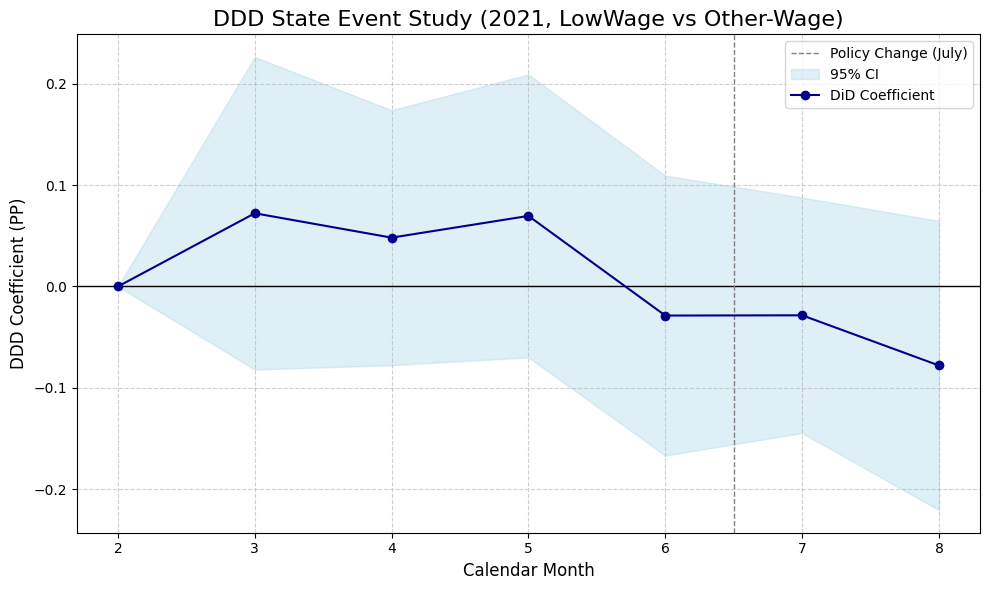


--- Calling analysis function for 2019 (Placebo) ---

--- RUNNING MAIN ANALYSIS (LowWage) FOR YEAR: 2019 ---

--- Step 3: Preparing Final 2019 STATE Panel (LowWage) ---
Created 'LowWage' variable from 'IND'.
Base 2019 panel (Holzer States, Feb-Aug, valid industry) constructed with 9359 observations.
Other Wage (n=6723), Low Wage (n=2636)

--- Step 4: Merging Controls into 2019 panel (LowWage) ---
Final 2019 panel with controls constructed with 9359 observations.

>>> FINAL MODEL: DDD (2019, All Ages, Holzer States, LowWage) <<<
Using formula:
found_job ~ TreatState * Post * LowWage + C(STATEFIP) + C(MONTH)

Starting 2019 DDD model estimation...

--- DDD Results (2019, All Ages, Holzer States, LowWage) ---
Key Coefficient (TreatState:Post:LowWage): 0.0557
P-value: 0.3134

--- Coefficient Summary (Key Variables) ---
TreatState:Post:LowWage  : Coef =   0.0557, P-val = 0.3134
TreatState:Post          : Coef =  -0.0021, P-val = 0.9372
TreatState:LowWage       : Coef =   0.0489, P-val = 0.0

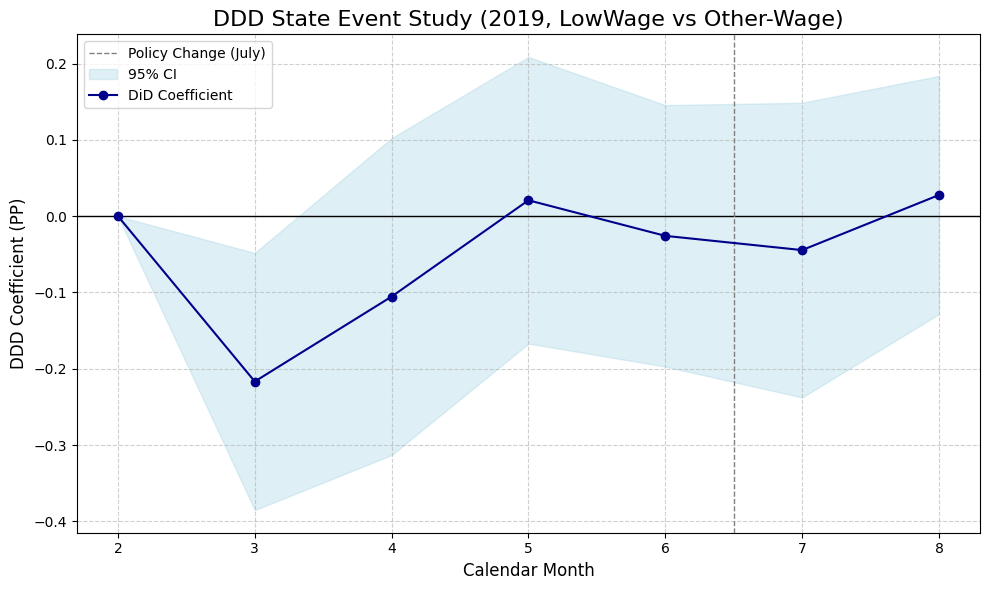


--- Calling sensitivity function for 2021 ---

--- RUNNING SENSITIVITY TEST (CollegeGrad) FOR YEAR: 2021 ---

--- Step 3: Preparing Final 2021 STATE Panel (CollegeGrad) ---
Created 'CollegeGrad' variable from 'EDUC'.
Base 2021 panel (Holzer States, Feb-Aug, valid education) constructed with 13443 observations.
Not College Grad (n=10076), College Grad (n=3367)

--- Step 4: Merging Controls into 2021 panel (CollegeGrad) ---
Final 2021 panel with controls constructed with 13443 observations.

>>> SENSITIVITY MODEL: DDD (2021, All Ages, Holzer States, CollegeGrad) <<<
Using formula:
found_job ~ TreatState * Post * CollegeGrad + log_monthly_cases + C(STATEFIP) + C(MONTH)

Starting 2021 DDD model estimation...

--- DDD Results (2021, All Ages, Holzer States, CollegeGrad) ---
Key Coefficient (TreatState:Post:CollegeGrad): 0.0382
P-value: 0.4613

--- Coefficient Summary (Key Variables) ---
TreatState:Post:CollegeGrad: Coef =   0.0382, P-val = 0.4613
TreatState:Post          : Coef =   0.0131,

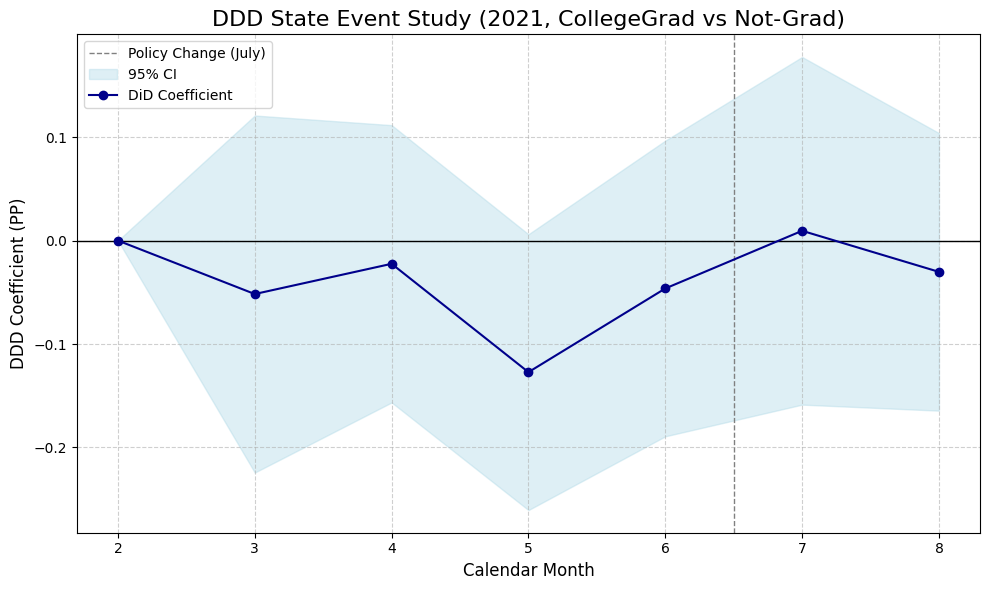

In [10]:

# =============================================================================
# CELL 5: SCRIPT ENTRY POINT (MODIFIED to call the new wrapper function)
# =============================================================================

if __name__ == '__main__':
    # Call the modified main execution function
    run_state_did_with_staggered_states(cps_file='cps_00005.csv')